<h1 align="center">Model selection</h1>

Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import PredefinedSplit
import pyarrow.parquet as pq
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from evaluation_functions import *


<h2 style="text-align: left;">Understanding the problem</h2>


Download data

In [24]:
random_seed = 42

In [2]:
parquet_file_path = '/home/oscar/data/feature_frame.parquet'
data = pq.read_table(parquet_file_path).to_pandas()
data.shape

(2880549, 27)

This sampling process is employed due to the large size of the dataset and the memory constraints that often lead to kernel crashes. To address this issue, we implement a sampling technique. However, instead of conducting random sampling, which could inadvertently remove specific products from transactions and introduce biases, we opt for a more structured approach.

We base our sampling on orders, ensuring that entire transactions are included in the sample. This method preserves the integrity of the data and prevents distortions that might arise from other sampling methods. By randomly selecting orders to include in our sample, we create a representative subset of the dataset that is smaller in size and more manageable for analysis.

In [3]:
order_ids = data['order_id'].unique()
sample_percentage = 0.2  

sample_orders_amount = int(len(order_ids) * sample_percentage)

sampled_orders = np.random.choice(order_ids, size=sample_orders_amount, replace=False)

sampled_data = data[data['order_id'].isin(sampled_orders)]

print("Original dataset size:", data.shape)
print("Sampled dataset size:", sampled_data.shape)

Original dataset size: (2880549, 27)
Sampled dataset size: (576959, 27)


In [4]:
data = sampled_data

Firstly, we have to select those orders which contain at least 5 items, so we can filter the Data Frame owing to this specification. 

In [5]:
num_products_ordered = data.groupby('order_id')['outcome'].sum()
orders_with_5_or_more_unique_products = num_products_ordered[num_products_ordered>=5].index

filtered_data = data[data['order_id'].isin(orders_with_5_or_more_unique_products)]

print(f"Number of total orders: {data['order_id'].nunique()}")
print(f"Number of orders with more than 5 products: {filtered_data['order_id'].nunique()}")

Number of total orders: 689
Number of orders with more than 5 products: 534


<h2 style="text-align: left;">Feature Selection</h2>

In [6]:
target = ['outcome']
id_features = ['variant_id', 'order_id', 'user_id']
temporal_features = ['created_at', 'order_date']
binary_features = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
categorical_features = ['product_type', 'vendor'] 
non_numerical_features = target + id_features+ temporal_features + categorical_features

numerical_features = [feature for feature in filtered_data.columns if feature not in non_numerical_features]

**IDENTIFICATION FEATURES**

The identifying variables, order_id, user_id, and variant_id, serve to uniquely identify orders, users, and variants in the dataset. However, they do not possess any predictive power regarding the outcome of interest. Therefore, these identifying variables will not appear in the final dataset used for predictive modeling or analysis. 

In [7]:
features_to_remove = id_features

**TEMPORAL FEATURES**

In the "temporal_features" section, it's noted that the two temporal variables are of type "object." This observation is crucial because it highlights that these variables are stored as strings rather than datetime objects. It's essential to keep this in mind when reading the dataset to ensure proper conversion into the datetime format.

Converting these variables into the datetime format is important for several reasons, particularly when performing tasks such as time series analysis, feature engineering, or data splitting into training and testing sets.

In [8]:
filtered_data.loc[:,'order_date'] = pd.to_datetime(filtered_data.loc[:,'order_date'])
filtered_data.loc[:,'created_at'] = pd.to_datetime(filtered_data.loc[:,'created_at'])

There features represent essentially the same information, where 'order_date' and 'created_at' both capture temporal data. However, 'created_at' includes the time component in addition to the date, while 'order_date' only represents the date without the time.

In [9]:
features_to_remove.append('created_at')
print(features_to_remove)

['variant_id', 'order_id', 'user_id', 'created_at']


**BINARY FEATURES**

We initially considered aggregating these binary variables in some way, but it has been observed that they are not highly correlated with each other. Moreover, some individual variables, such as 'abandoned_before,' exhibit significant importance on their own for predicting the response variable.

In [10]:
print(filtered_data.groupby('abandoned_before')['outcome'].mean() * 100)

abandoned_before
0.0     1.350638
1.0    70.879121
Name: outcome, dtype: float64


When 'abandoned_before' is 0.0, indicating that the customer has not abandoned an order before, the mean purchase rate is approximately 1.39%. Conversely, when 'abandoned_before' is 1.0, indicating that the customer has previously abandoned an order, the mean purchase rate drastically increases to approximately 75.08%. This substantial difference in purchase rates suggests that the 'abandoned_before' variable holds considerable predictive power on its own in determining the likelihood of purchase.

In [11]:
print("Correlation Matrix between binary features:")
print(filtered_data[binary_features].corr())

Correlation Matrix between binary features:
                  ordered_before  abandoned_before  active_snoozed  \
ordered_before          1.000000          0.050160        0.259240   
abandoned_before        0.050160          1.000000        0.033951   
active_snoozed          0.259240          0.033951        1.000000   
set_as_regular          0.304041          0.050408        0.101380   

                  set_as_regular  
ordered_before          0.304041  
abandoned_before        0.050408  
active_snoozed          0.101380  
set_as_regular          1.000000  


**CATEGORICAL FEATURES**

The initial intention is to encode these variables by frequency. However, it's not feasible to perform this encoding directly on the initial dataset. Instead, it must be done separately for each split. This approach is necessary to prevent data leakage or contamination between the splits, which could lead to an overly optimistic estimation of model performance.

**NUMERICAL FEATURES**

The correlation matrices provide insights into linear relationships between variables, but it's important to note that non-linear relationships may exist, which are not captured by these matrices. Given this context, observing the correlation matrix provided, we can make several observations:

* The variables "avg_days_to_buy_variant_id" and "std_days_to_buy_variant_id" show moderate correlation with "days_since_purchase_variant_id."

* The variable "days_since_purchase_product_type" displays moderate correlation with "days_since_purchase_variant_id." 

* The variable "avg_days_to_buy_product_type" exhibits moderate correlation with "avg_days_to_buy_variant_id" and "std_days_to_buy_variant_id." 

Despite these observations, it's essential to remember that correlation matrices do not capture all relationships between variables, especially non-linear ones. Therefore, no variables will be eliminated at this point due to the possibility of non-linear relationships not reflected in these matrices.

In [12]:
print(filtered_data[[
    'days_since_purchase_variant_id',
    'avg_days_to_buy_variant_id',
    'std_days_to_buy_variant_id',
    'days_since_purchase_product_type',
    'avg_days_to_buy_product_type',
    'std_days_to_buy_product_type',
    'outcome'
]].corr())

                                  days_since_purchase_variant_id  \
days_since_purchase_variant_id                          1.000000   
avg_days_to_buy_variant_id                              0.028069   
std_days_to_buy_variant_id                              0.031371   
days_since_purchase_product_type                        0.211286   
avg_days_to_buy_product_type                            0.008613   
std_days_to_buy_product_type                            0.009315   
outcome                                                 0.032057   

                                  avg_days_to_buy_variant_id  \
days_since_purchase_variant_id                      0.028069   
avg_days_to_buy_variant_id                          1.000000   
std_days_to_buy_variant_id                          0.598271   
days_since_purchase_product_type                    0.008238   
avg_days_to_buy_product_type                        0.292035   
std_days_to_buy_product_type                        0.251033   
outcome

Variables related to family members were likely imputed mostly with the median, as observed in the exploratory data analysis (EDA). However, due to this imputation strategy, they may introduce more noise than information into the dataset. Therefore, they will not be used in the analysis.

In [13]:
features_to_remove.extend(['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'])
print(features_to_remove)

['variant_id', 'order_id', 'user_id', 'created_at', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby']


**FINAL DATA**

In [14]:
final_data = filtered_data.drop(features_to_remove, axis=1)

<h2 style="text-align: left;">Getting training, validation and testing</h2>

**INITIAL SPLITTING (FINALLY NOT USED)**

In order to avoid information leakage, we must consider several key factors:
* We have to ensure that the same 'user_id' does not appear in both the training and testing datasets is crucial. This can lead to data leakage, compromisiing the integrity of the evaluation.
* It's essential to mantain the assumption that the training and testing datasets are independentrly and identically distributed to ensure the model's performance on the test data accurately reflexts its ability to generalize to unseen data

As we have **an imbalanced dataset**, we'll split the dataset into training and testing sets using **stratification**, and based on avoiding information leakage by user.

In [13]:
unique_users = data['user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2)

In [14]:
train_data = data[data['user_id'].isin(train_users)]
test_data = data[data['user_id'].isin(test_users)]

In [15]:
X_train = train_data.drop('outcome', axis=1)
y_train = train_data['outcome']

X_test = test_data.drop('outcome', axis=1)
y_test = test_data['outcome']

In [16]:
print("Train set size:", len(train_data)/(len(train_data)+len(test_data)))
print("Test set size:", len(test_data)/(len(train_data)+len(test_data)))

Train set size: 0.7969782843478795
Test set size: 0.2030217156521205


Overall, the proportion of examples for each class is maintained well between the train and test sets. Despite the class imbalance, the proportion remains consistent across both sets. This suggests that stratifying the data during the train-test split may not be necessary in this case, as the imbalance is preserved in both sets without intervention. However, it's important to note that this imbalance might affect the performance of some classifiers, and strategies such as oversampling or undersampling of the minority class may be considered to address this issue.

In [17]:
train_class_percentages = train_data['outcome'].value_counts(normalize=True) * 100
test_class_percentages = test_data['outcome'].value_counts(normalize=True) * 100

print("Percentage of examples for each class in train set:")
print(train_class_percentages)
print("\nPercentage of examples for each class in test set:")
print(test_class_percentages)

Percentage of examples for each class in train set:
outcome
0.0    98.842506
1.0     1.157494
Name: proportion, dtype: float64

Percentage of examples for each class in test set:
outcome
0.0    98.861347
1.0     1.138653
Name: proportion, dtype: float64


The approach described above was a way to split the data without considering the temporal reference. Initially, I assumed that temporal information might not be crucial as there was already data available on the days since the last purchase, etc. However, upon further consideration, I realized the importance of incorporating temporal information into the data splitting process.

To address this, I devised another approach for splitting the data based on this temporal reference. This new approach involves dividing the dataset into training and testing sets while ensuring that the temporal sequence is preserved. By doing so, we aim to account for any temporal dependencies or patterns in the data, which may be critical for accurately modeling and predicting future outcomes.

**NEW SPLITTING**

When separating data, it's crucial to consider the date on which orders are placed for several reasons. Firstly, the temporal aspect provides valuable insights into patterns and trends over time, which can significantly impact the performance of predictive models. By incorporating temporal information into the data splitting process, we ensure that the training data represents past observations, while the testing or validation data represents future observations, mimicking real-world scenarios.

Moreover, not considering the date of orders can lead to a phenomenon known as data leakage. Data leakage occurs when information from the future or unseen data is inadvertently included in the training process, leading to overly optimistic performance estimates of the model. In the context of order data, if future information, such as orders placed after a certain date, is included in the training set, the model may learn patterns that do not generalize well to unseen data, resulting in poor model performance when deployed in production.

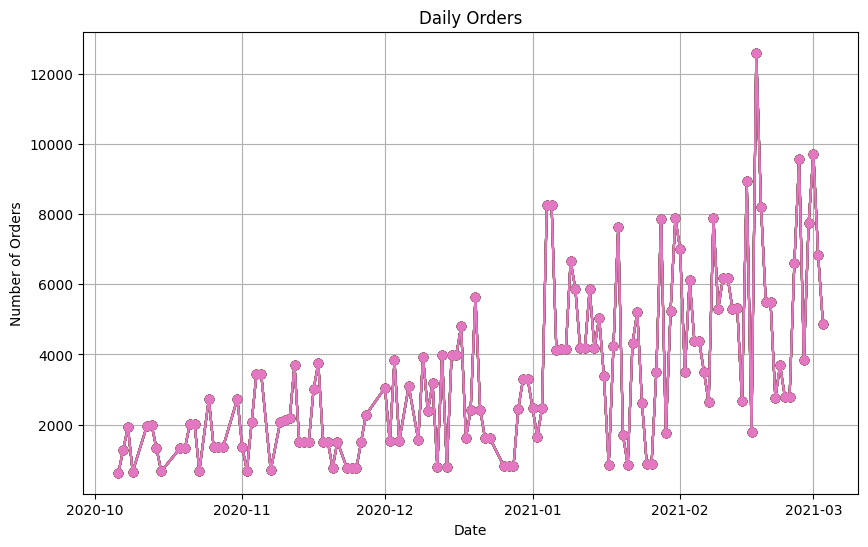

In [15]:
daily_orders = final_data.groupby('order_date').count()
plt.figure(figsize=(10, 6)) 
plt.plot(daily_orders, marker='o', linestyle='-')  
plt.title('Daily Orders')  
plt.xlabel('Date')  
plt.ylabel('Number of Orders')
plt.grid(True) 
plt.show()

Firstly, we should conduct research regarding date information:

In [16]:
print("Minimum order date:", final_data['order_date'].min())
print("Maximum order date:", final_data['order_date'].max())

Minimum order date: 2020-10-06 00:00:00
Maximum order date: 2021-03-03 00:00:00


The criterion followed for the separation is based on dividing the data into three sets: training, validation, and testing, while maintaining a temporal relationship among them. This approach ensures that the model is trained on data from an earlier period than the validation and testing data.

Specifically, the data is divided into three parts using quantiles based on the order dates. Approximately 70% of the data is allocated to the training set, while approximately 15% each is allocated to the validation and testing sets. This allocation strategy considers the distribution of orders over time, aiming to prevent information contamination between sets.

Adhering to this temporal relationship is crucial for preventing the model from learning patterns specific to the validation and testing data, thus promoting its generalization ability to unseen data effectively. Moreover, allocating a larger portion of data to training ensures that the model learns from a diverse range of examples, which enhances its overall performance and robustness.

In [17]:
final_data_sorted = final_data.sort_values(by='order_date')

train_end = final_data_sorted['order_date'].quantile(0.7)
val_end = final_data_sorted['order_date'].quantile(0.85)
test_end = final_data_sorted['order_date'].quantile(1)


train_data = final_data_sorted[final_data_sorted['order_date'] < train_end]
val_data = final_data_sorted[(final_data_sorted['order_date'] >= train_end) & (final_data_sorted['order_date'] < val_end)]
test_data = final_data_sorted[(final_data_sorted['order_date'] >= val_end) & (final_data_sorted['order_date'] <= test_end)]

print("Training set size:", (train_data.shape[0] / final_data_sorted.shape[0]))
print("Validation set size:", (val_data.shape[0] / final_data_sorted.shape[0]))
print("Testing set size:", (test_data.shape[0] / final_data_sorted.shape[0]))

Training set size: 0.6973985772873282
Validation set size: 0.14041711654885553
Testing set size: 0.16218430616381624


These dates represent the end points of each subset:

* The training set ends on February 9, 2021, at midnight.
* The validation set ends on February 21, 2021, at midnight.
* The testing set ends on March 3, 2021, at midnight.

**Possible issue**: What if I have a user who makes purchases in both the training and testing sets? Will the model learn from that user? Is there a risk of data leakage?

In [18]:
X_train = train_data.drop(columns=['outcome', 'order_date'])
y_train = train_data['outcome']

X_val = val_data.drop(columns=['outcome', 'order_date'])
y_val = val_data['outcome']

X_test = test_data.drop(columns=['outcome', 'order_date'])
y_test = test_data['outcome']

<h2 style="text-align: left;">Data training</h2>

1. **Logistic Regression l2 - Ridge**

Before diving into model training, we undertake a preprocessing step, the encoding of categorical features.

In this context, we employ the Count Encoding technique, which involves replacing categorical values with the frequency of their occurrences within the dataset. Unlike One-Hot Encoding, which can lead to an explosion in the number of features, especially when dealing with categorical features with numerous unique values, Count Encoding mitigates this issue by providing a compact representation of categorical data.

Moreover, we opt against using Target Encoding at this stage due to potential concerns related to class imbalance. Target Encoding, which involves replacing categorical values with the mean of the target variable within each category, may risk overfitting, particularly when dealing with imbalanced classes.

In [19]:
columns_to_encode = categorical_features

column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', ce.CountEncoder(min_group_size=1.0), columns_to_encode)
    ],
    remainder='passthrough' 
)

After encoding categorical variables, we perform variable normalization, a crucial step in logistic regression, primarily due to its sensitivity to the scale of the features. Moreover, Ridge regularization is employed as the initial regularization technique in our model pipeline. This is done to address potential issues such as overfitting and multicollinearity.

Ridge regularization adds a penalty term to the coefficient estimates during model training, which helps prevent overfitting by reducing the magnitude of the coefficients. By starting with Ridge regularization, we ensure that no variables are overly penalized initially, allowing the model to learn from the data more effectively.

To optimize the model, we aim to find the highest area under the precision-recall curve (AUC-PR) due to several key reasons:

* Independent of Threshold: The AUC-PR metric remains independent of the threshold and focuses solely on the positive class, making it suitable for evaluating the model's performance in identifying potential purchasers regardless of the classification threshold. 

* Sensitivity to Trade-offs: Our objective of increasing monthly sales by 2% and boosting selected items by 25% requires a balanced consideration of trade-offs between correctly identifying purchasers (recall) and minimizing false positives (precision). AUC-PR enables us to optimize this trade-off effectively, ensuring efficient resource allocation and maximizing the impact on sales performance.

* Comprehensive Assessment: By encompassing the entire range of possible recall-precision trade-offs, AUC-PR offers a comprehensive evaluation of the model's performance. It captures the model's ability to correctly classify positive instances while also minimizing missed opportunities, aligning well with our overarching goal of improving sales performance and focusing on specific items for growth.

In [28]:
score = metrics.make_scorer(metrics.average_precision_score, greater_is_better=True,needs_threshold=True)

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [30]:
pipe = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression(solver='newton-cg', penalty='l2'))
])


reg_values = np.geomspace(0.00001, 1e+4, num=10)
parameters = {'reg__C': 1.0/reg_values}

gridsearch = GridSearchCV(pipe, parameters,  
                          scoring=score, 
                          return_train_score=True)

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         CountEncoder(combine_min_nan_groups=True,
                                                                                      min_group_size=1.0),
                                                                         ['product_type',
                                                                          'vendor'])])),
                                       ('scaler', StandardScaler()),
                                       ('reg',
                                        LogisticRegression(solver='newton-cg'))]),
             param_grid={'reg__C': array([1.e+05, 1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02,
       1.e-03, 1.e-04])},
             return_train_score=True,
             scoring=make_scorer(average_precision_score, response_method=('decision_function', 'predict_proba')))

In [31]:
results = pd.DataFrame(gridsearch.cv_results_)

results = results[['param_reg__C', 'mean_test_score', 'mean_train_score']]

results['param_reg__C'] = 1 / results['param_reg__C']

results = results.rename(columns={'param_reg__C': 'Regularization', 'mean_test_score': 'Mean Test Score', 'mean_train_score': 'Mean Train Score'})
results

,Regularization,Mean Test Score,Mean Train Score
0,0.00001,0.157659,0.159236
1,0.0001,0.157659,0.159236
2,0.001,0.157659,0.159236
3,0.01,0.157659,0.159236
4,0.1,0.157659,0.159236
5,1.0,0.157662,0.159240
6,10.0,0.157701,0.159265
7,100.0,0.158018,0.159493
8,1000.0,0.159897,0.160518
9,10000.0,0.161782,0.156550


The confusion matrix highlights the model's strong performance in correctly classifying non-purchases (true negatives), minimizing unnecessary notifications to users who are unlikely to engage with the product. However, the model struggles to accurately identify individuals who are likely to make a purchase (true positives), leading to missed opportunities for engagement and potential sales.

In [34]:
best_estimator = gridsearch.best_estimator_
print('The best lambda value is:', 1/best_estimator['reg'].C)
evaluate_classifier(best_estimator, X_val, y_val)

The best lambda value is: 10000.0
Mean recall by classes is 51.50
Geometric mean is 17.38
Fscore is 5.75
Confusion Matrix:
[[   25   802]
 [   17 61710]]


To gain a deeper understanding of the model's behavior, we examined the coefficients associated with each of the features:

* It is observed that "ordered_before," "abandoned_before," and "global_popularity" exhibit relatively high positive coefficients, indicating their strong relationship with the predictive variable and their significance in predicting the response variable. 

* The "price" and "days_since_purchase_product" features show negative coefficients, suggesting that as the number of days since the purchase or the price of the product increases, there is a decrease in the likelihood of purchasing the product.

* Many variables such as "product type," "vendor," and "product type encoding" do not exhibit coefficients, possibly due to their categorical nature. This implies that the model may not be effectively leveraging these variables in its predictions.

¿Possible solutions?

- Feature engineering to explore alternative transformations to categorical variables
- Incorporating domain knowledge to refine relevant features to enhance the model's predicitve performance

In [33]:
coefficients = best_estimator.named_steps['reg'].coef_[0]
feature_names = best_estimator.named_steps['preprocessor'].get_feature_names_out()

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

print(coefficients_df)


                                        Feature  Coefficient
3                     remainder__ordered_before     0.296195
9                  remainder__global_popularity     0.187027
4                   remainder__abandoned_before     0.125673
6                     remainder__set_as_regular     0.035284
0                         encoder__product_type     0.030520
13  remainder__days_since_purchase_product_type     0.017107
5                     remainder__active_snoozed     0.016645
10    remainder__days_since_purchase_variant_id     0.015785
8                       remainder__discount_pct    -0.002459
1                               encoder__vendor    -0.004658
12        remainder__std_days_to_buy_variant_id    -0.009151
15      remainder__std_days_to_buy_product_type    -0.009193
2                     remainder__user_order_seq    -0.017789
14      remainder__avg_days_to_buy_product_type    -0.018268
11        remainder__avg_days_to_buy_variant_id    -0.038181
7                   rema

It's noteworthy that we achieved an area under the ROC curve (AUC) over 80. However, it's important to interpret this metric cautiously due to the nature of our dataset. We have a considerable number of negative cases (non-purchases), which can heavily influence the ROC curve's false positive rate (FPR). In simpler terms, the AUC might appear high due to the large number of true negatives, but this doesn't necessarily reflect the model's effectiveness in correctly identifying positive instances (purchases). 

Area under the ROC curve for Regresión logística Ridge: 82.79


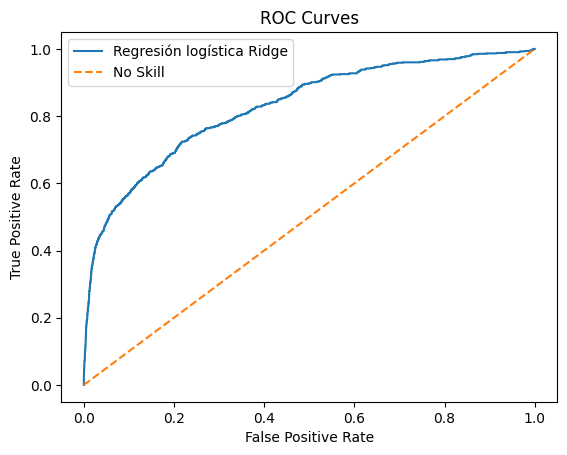

In [38]:
plot_ROC_curve([best_estimator], X_val, y_val, ['Regresión logística Ridge'])

The area under the precision-recall (PR) curve for the Ridge Logistic Regression model is reported as 0.16. This indicates the model's performance in terms of precision and recall, which are crucial for our sales prediction task. However, the relatively low value of 0.16 suggests that the model may struggle to effectively balance precision and recall, resulting in suboptimal performance.

Area under the PR curve for Regresión logística Ridge: 0.16


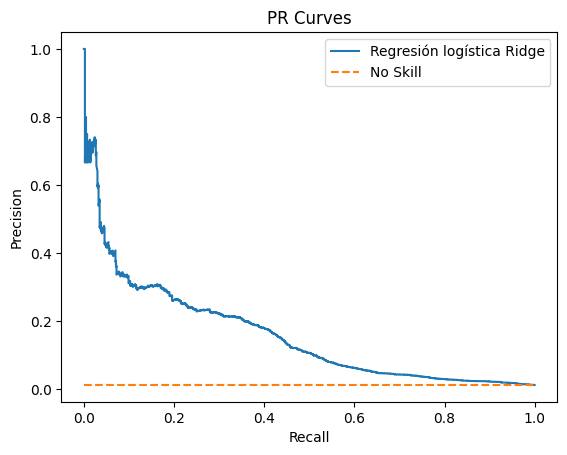

In [39]:
plot_PR_curve([best_estimator], X_val, y_val, ['Regresión logística Ridge'])

<h2 style="text-align: left;">Threshold finding</h2>

The precision-recall curve for different classification thresholds indicates that achieving a balance between precision and recall would require a threshold of approximately 0.1. At this threshold, the curve suggests that we could attain a recall of approximately 0.2 and a precision of 0.2.

In simpler terms, setting the classification threshold to 0.1 means that the model would classify instances as positive (purchase) if the predicted probability of being positive exceeds 0.1. At this threshold, the model achieves a recall of 0.2, meaning that it correctly identifies around 20% of all actual positive instances (purchases). Additionally, it achieves a precision of 0.2, indicating that out of all instances classified as positive, only 20% are actually true positives (correct predictions).

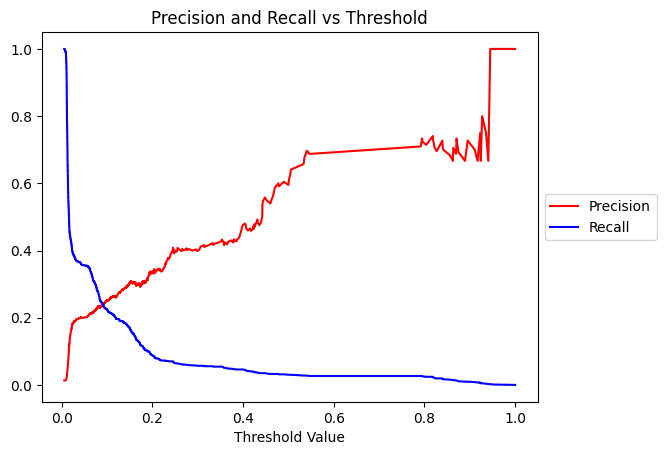

In [41]:
plot_precision_recall_vs_threshold(best_estimator, X_val, y_val)

The F-score of the best model on the test dataset after optimizing the threshold is reported as 24.36%. This indicates an improvement in the model's performance when compared to previous evaluations. However, it's crucial to interpret these results in the context of our business objectives.

While the optimization of the threshold has led to better performance in production, it's important to acknowledge that there is still room for improvement. The relatively low number of true positives suggests that the model may not be effectively identifying all potential purchasers. Moreover, the high number of false positives indicates that a significant portion of users who are unlikely to make a purchase would still receive notifications, potentially leading to user dissatisfaction and resource wastage.

In [42]:
evaluate_best_threshold_test(best_estimator, 0.1, X_test, y_test, metric='fscore')

Fscore of the best model on test after optimizing threshold 24.36
[[  201   719]
 [  529 70802]]


Insights of Logistic Regression Ridge:

* The threshold that achieves a certain balance between recall and precision is 0.1.

* An F-score of 25 is achieved in production by decreasing the threshold, resulting in an increase in false positives (FP). This F-score is relatively good in classifying non-purchasers but performs worse in identifying actual purchasers.

* Coefficients associated with categorical variables are very low, indicating a need to possibly redefine the encoding method, such as associating variables with target encoding or other encoding techniques.

2. **Logistic Regression l2 - Lasso**

Reasons to use Lasso:

* Feature Selection: Lasso regularization, based on the L1 norm penalty, has the property of encouraging sparsity in the coefficient vector. This means it tends to shrink coefficients of less important features to zero, effectively performing feature selection. By doing so, it can help in identifying and eliminating features that are less relevant to the prediction task, leading to a simpler and more interpretable model.

* Underlying Noise Distribution: Lasso regularization assumes a Laplacian noise distribution in contrast to Ridge regularization, which assumes a Gaussian noise distribution. The Laplacian distribution is more robust to outliers compared to the Gaussian distribution. 

* Exploring Alternatives: Using Lasso regularization now provides an opportunity to explore whether it yields different results compared to Ridge regularization. By comparing the performance of Lasso and Ridge regularization, we can gain insights into which regularization technique is more suitable for our specific dataset and prediction task. This comparative analysis helps in understanding the underlying structure of the data and selecting the most appropriate regularization approach for improved model performance.

In [45]:
pipe = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression(solver='saga',penalty='l1'))
])


reg_values = np.geomspace(0.00001, 1e+4, num=10)
parameters = {'reg__C': 1.0/reg_values}

gridsearch = GridSearchCV(pipe, parameters,  
                          scoring=score, 
                          return_train_score=True)

gridsearch.fit(X_train, y_train)

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         CountEncoder(combine_min_nan_groups=True,
                                                                                      min_group_size=1.0),
                                                                         ['product_type',
                                                                          'vendor'])])),
                                       ('scaler', StandardScaler()),
                                       ('reg',
                                        LogisticRegression(penalty='l1',
                                                           solver='saga'))]),
             param_grid={'reg__C': array([1.e+05, 1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02,
       1.e-03, 1.e-04])},
             return_train_score=True,
             scoring=make_scorer(average_precision_score, response_method=('decision_function', 'predict_proba')))

In [46]:
results = pd.DataFrame(gridsearch.cv_results_)

results = results[['param_reg__C', 'mean_test_score', 'mean_train_score']]

results['param_reg__C'] = 1 / results['param_reg__C']

results = results.rename(columns={'param_reg__C': 'Regularization', 'mean_test_score': 'Mean Test Score', 'mean_train_score': 'Mean Train Score'})
results

,Regularization,Mean Test Score,Mean Train Score
0,0.00001,0.158213,0.159430
1,0.0001,0.158213,0.159430
2,0.001,0.158212,0.159430
3,0.01,0.158213,0.159430
4,0.1,0.158211,0.159432
5,1.0,0.158231,0.159453
6,10.0,0.159421,0.159524
7,100.0,0.166467,0.160347
8,1000.0,0.170770,0.161392
9,10000.0,0.014558,0.014558


In [47]:
best_estimator = gridsearch.best_estimator_
print('The best lambda value is:', 1/best_estimator['reg'].C)
evaluate_classifier(best_estimator, X_val, y_val)

The best lambda value is: 1000.0
Mean recall by classes is 51.65
Geometric mean is 18.39
Fscore is 6.21
Confusion Matrix:
[[   28   799]
 [   47 61680]]


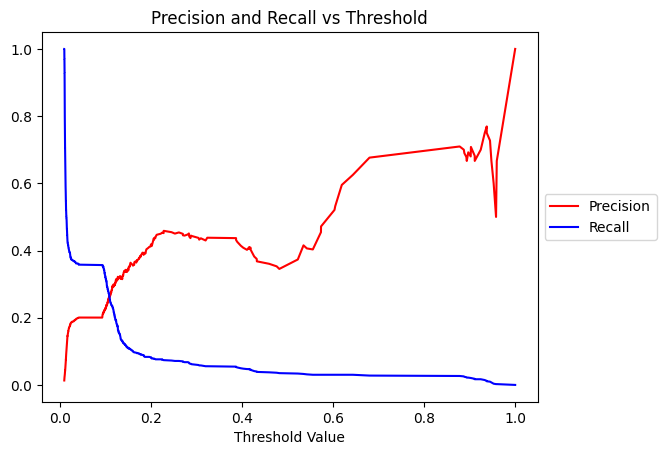

In [48]:
plot_precision_recall_vs_threshold(best_estimator, X_val, y_val)

In [49]:
evaluate_best_threshold_test(best_estimator, 0.1, X_test, y_test, metric='fscore')

Fscore of the best model on test after optimizing threshold 24.50
[[  282   638]
 [ 1100 70231]]


<h2 style="text-align: left;">Final Insights</h2>

* The performance between Lasso and Ridge regularization techniques exhibits considerable similarity. Both methods yield comparable results in terms of predictive performance and model behavior.

* The categorical variables, as currently encoded, do not provide significant predictive information. Further exploration is required to determine alternative encoding methods or conduct feature engineering to extract useful insights from these variables.

* The ROC curve does not offer meaningful insights in this business problem. This is because the true negatives (TN) significantly outnumber the false positives (FP), resulting in a very small false positive rate (FPR), which makes it challenging to discern differences in model performance.

* The precision-recall curve provides valuable information. It indicates a balanced trade-off between precision and recall at approximately 0.2 for both metrics, suggesting an optimal threshold for classification.

* There is a clear need to optimize the model further. This involves exploring methods such as feature association, alternative encodings for categorical variables, and experimenting with different parameter combinations in the pipelines to uncover a more effective and optimal model.